In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


In [2]:
!nvidia-smi

Tue Jul  8 15:54:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch

torch.cuda.empty_cache()
num_gpus = torch.cuda.device_count()
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

GPU 0: Tesla P100-PCIE-16GB


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

torch.manual_seed(42)

class nn_wrapper:
    class neural_network(torch.nn.Module):
        def __init__(self, input_size: int, output_size: int):
            """
            Much deeper feed-forward neural network for classification.
            """
            super().__init__()
            self.fc1 = torch.nn.Linear(input_size, 2048)
            self.bn1 = torch.nn.BatchNorm1d(2048)
            self.dropout1 = torch.nn.Dropout(0.4)
    
            self.fc2 = torch.nn.Linear(2048, 2048)
            self.bn2 = torch.nn.BatchNorm1d(2048)
            self.dropout2 = torch.nn.Dropout(0.4)
    
            self.fc3 = torch.nn.Linear(2048, 1024)
            self.bn3 = torch.nn.BatchNorm1d(1024)
            self.dropout3 = torch.nn.Dropout(0.4)
    
            self.fc4 = torch.nn.Linear(1024, 1024)
            self.bn4 = torch.nn.BatchNorm1d(1024)
            self.dropout4 = torch.nn.Dropout(0.4)
    
            self.fc5 = torch.nn.Linear(1024, 512)
            self.bn5 = torch.nn.BatchNorm1d(512)
            self.dropout5 = torch.nn.Dropout(0.3)
    
            self.fc6 = torch.nn.Linear(512, 512)
            self.bn6 = torch.nn.BatchNorm1d(512)
            self.dropout6 = torch.nn.Dropout(0.3)
    
            self.fc7 = torch.nn.Linear(512, 256)
            self.bn7 = torch.nn.BatchNorm1d(256)
            self.dropout7 = torch.nn.Dropout(0.2)
    
            self.fc8 = torch.nn.Linear(256, 128)
            self.bn8 = torch.nn.BatchNorm1d(128)
            self.dropout8 = torch.nn.Dropout(0.2)
    
            self.fc9 = torch.nn.Linear(128, 64)
            self.bn9 = torch.nn.BatchNorm1d(64)
            self.dropout9 = torch.nn.Dropout(0.1)
    
            self.fc10 = torch.nn.Linear(64, output_size)
            self.relu = torch.nn.ReLU()
    
        def forward(self, x: torch.Tensor) -> torch.Tensor:
            x = self.fc1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.dropout1(x)
    
            x = self.fc2(x)
            x = self.bn2(x)
            x = self.relu(x)
            x = self.dropout2(x)
    
            x = self.fc3(x)
            x = self.bn3(x)
            x = self.relu(x)
            x = self.dropout3(x)
    
            x = self.fc4(x)
            x = self.bn4(x)
            x = self.relu(x)
            x = self.dropout4(x)
    
            x = self.fc5(x)
            x = self.bn5(x)
            x = self.relu(x)
            x = self.dropout5(x)
    
            x = self.fc6(x)
            x = self.bn6(x)
            x = self.relu(x)
            x = self.dropout6(x)
    
            x = self.fc7(x)
            x = self.bn7(x)
            x = self.relu(x)
            x = self.dropout7(x)
    
            x = self.fc8(x)
            x = self.bn8(x)
            x = self.relu(x)
            x = self.dropout8(x)
    
            x = self.fc9(x)
            x = self.bn9(x)
            x = self.relu(x)
            x = self.dropout9(x)
    
            x = self.fc10(x)
            return x
            
    def __init__(self, train_data: pd.DataFrame, test_data: pd.DataFrame):
        """
        Initializes the wrapper, splits data, and sets up the model, loss, and optimizer.
        """
        self.device = self.check_device()

        self.train_data = train_data
        self.columns = train_data.columns
        self.test_data = test_data
        self.test_data_index = test_data.index
        self.test_data = self.test_data.apply(pd.to_numeric, errors='raise')
        self.test_data = torch.tensor(test_data.values, dtype=torch.float32)

        if self.device != "cpu":
            self.test_data = self.test_data.to(self.device)
        
        self.percentage = 0.8  # Percentage of data to use for training
        self.X_train, self.y_train, self.X_validation, self.y_validation = self.train_val_split()

        self.train_dataset = TensorDataset(self.X_train, self.y_train)
        self.validation_dataset = TensorDataset(self.X_validation, self.y_validation)

        self.batch_size = 512
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.validation_loader = DataLoader(self.validation_dataset, batch_size=self.batch_size)

        input_size = self.X_train.shape[1]
        output_size = torch.unique(self.y_train).numel()

        self.model = self.neural_network(input_size, output_size).to(self.device)
        self.epochs = 100
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=0.0005)

        self.train_history = []
        self.validation_history = []

    def check_device(self) -> str:
        """
        Checks and returns the available device: 'cuda', 'mps', or 'cpu'.
        """
        if torch.cuda.is_available():
            device = "cuda" # NVIDIA GPU
        elif torch.backends.mps.is_available():
            device = "mps" # Apple GPU
        else:
            device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available
        print(f"Using device: {device}")
        return device

    def train_val_split(self) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Shuffles and splits the training data into training and validation sets.
        Returns:
            X_train, y_train, X_validation, y_validation (all as torch.Tensors)
        """

        length = self.train_data.shape[0]
        shuffled_data = self.train_data.sample(frac=1).reset_index(drop=True)

        train_samples = int(length * self.percentage)

        train_data = shuffled_data[:train_samples]
        validation_data = shuffled_data[train_samples:]

        # Assume last column is the label
        X_train = train_data.iloc[:, :-1]
        y_train = train_data.iloc[:, -1]
        X_validation = validation_data.iloc[:, :-1]
        y_validation = validation_data.iloc[:, -1]

        X_train = torch.tensor(X_train.values, dtype=torch.float32)
        y_train = torch.tensor(y_train.values, dtype=torch.long)
        X_validation = torch.tensor(X_validation.values, dtype=torch.float32)
        y_validation = torch.tensor(y_validation.values, dtype=torch.long)

        if self.device != "cpu":
            X_train = X_train.to(self.device)
            X_validation = X_validation.to(self.device)
            y_train = y_train.to(self.device)
            y_validation = y_validation.to(self.device)

        return X_train, y_train, X_validation, y_validation 

    def train(self, plot=False) -> None:
        """
        Trains the neural network for a given number of epochs using mini-batches.
        """
        print("Training...")       

        early_stopping = 0
        prev_validation_loss_epoch = 0
        early_stopping_limit = 5
        epsillon = 10e-7

        len_train_dataset = len(self.train_dataset)
        len_val_dataset = len(self.validation_dataset)
        
        for epoch in range(self.epochs):
            self.model.train()
            train_loss_epoch = 0.0
            for X_batch, y_batch in self.train_loader:
                y_pred = self.model(X_batch)
                train_loss = self.loss_fn(y_pred, y_batch)
                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()
                train_loss_epoch += train_loss.item() * X_batch.size(0)

            train_loss_epoch /= len_train_dataset

            # Validation
            self.model.eval()
            validation_loss_epoch = 0.0
            with torch.inference_mode():
                for X_batch, y_batch in self.validation_loader:
                    validation_pred = self.model(X_batch)
                    validation_loss = self.loss_fn(validation_pred, y_batch)
                    validation_loss_epoch += validation_loss.item() * X_batch.size(0)
            validation_loss_epoch /= len_val_dataset

            self.train_history.append(train_loss_epoch)
            self.validation_history.append(validation_loss_epoch)

            # Early Stopping
            if len(self.validation_history) > 1 and abs(self.validation_history[-1] - self.validation_history[-2]) < epsillon:
                print (f"difference: {abs(self.validation_history[-1] - self.validation_history[-2]):.8f}")
                early_stopping += 1
                if early_stopping == early_stopping_limit:
                    print (f"The validation loss difference has been insignificant for {early_stopping_limit} times. Stopping training.")
                    break
            else:
                if early_stopping != 0:
                    early_stopping = 0
                    print("Early stopping reset.")

            if epoch % 10 == 0:
                print(f"Epoch: {epoch + 1} | Train loss: {train_loss_epoch:.4f} | validation loss: {validation_loss_epoch:.4f}")

        if plot:
            plt.figure(figsize=(8, 5))
            plt.plot(self.train_history, label="Train Loss")
            plt.plot(self.validation_history, label="Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Training and Validation Loss")
            plt.legend()
            plt.show()

    def calculate_metrics(self) -> dict[str, float]:
        """
        Calculates and prints accuracy, precision, recall, and F1-score on the validation set.
        Returns:
            Dictionary with metric names and values.
        """
        self.model.eval()
        with torch.inference_mode():
            y_pred = self.model(self.X_validation)
            _, predicted = torch.max(y_pred, 1)
            y_true = self.y_validation.cpu().numpy()
            y_pred_np = predicted.cpu().numpy()

            accuracy = accuracy_score(y_true, y_pred_np)
            precision = precision_score(y_true, y_pred_np, average='weighted', zero_division=0)
            recall = recall_score(y_true, y_pred_np, average='weighted', zero_division=0)
            f1 = f1_score(y_true, y_pred_np, average='weighted', zero_division=0)

            print("| Metric    | Value  |")
            print("|-----------|--------|")
            print(f"| Accuracy  | {accuracy:.4f} |")
            print(f"| Precision | {precision:.4f} |")
            print(f"| Recall    | {recall:.4f} |")
            print(f"| F1-score  | {f1:.4f} |")

            return {
                "accuracy": float(accuracy),
                "precision": float(precision),
                "recall": float(recall),
                "f1": float(f1)
            }
        
    def predict(self) -> pd.DataFrame:
        """
        Predicts class labels for the test data.
        Returns:
            pd.DataFrame with predictions, indexed by the original test data index,
            and columns for each of the top 3 predictions.
        """
        self.model.eval()
        with torch.inference_mode():
            y_pred = self.model(self.test_data)
            _, topk_indices = torch.topk(y_pred, k=3, dim=1)  # shape: [num_samples, 3]
            topk_np = topk_indices.cpu().numpy()
            df = pd.DataFrame(topk_np, index=self.test_data_index, columns=["Prediction_1", "Prediction_2", "Prediction_3"])
        return df 
    
    def save_model(self, path: str) -> None:
        """
        Saves the trained model to the specified path.
        Args:
            path (str): Path where the model will be saved.
        """
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

In [5]:
train_data = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')

In [6]:
fertilizer_to_index = {}
for index, fertilizer in enumerate(train_data["Fertilizer Name"].unique()):
    fertilizer_to_index[fertilizer] = index

index_to_fertilizer = {index: fertilizer for fertilizer, index in fertilizer_to_index.items()}

soil_to_index = {}
for index, soil in enumerate(train_data["Soil Type"].unique()):
    soil_to_index[soil] = index

crop_to_index = {}
for index, crop in enumerate(train_data["Crop Type"].unique()):
    crop_to_index[crop] = index

In [7]:
train_data = train_data.replace({
    "Fertilizer Name": fertilizer_to_index,
    "Soil Type": soil_to_index,
    "Crop Type": crop_to_index
    })

test_data = test_data.replace({
    "Soil Type": soil_to_index,
    "Crop Type": crop_to_index,})

/tmp/ipykernel_19/4199030178.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data = train_data.replace({
/tmp/ipykernel_19/4199030178.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data = test_data.replace({


In [8]:
train_data = train_data.drop(['id'], axis=1)
test_data_id = test_data['id']
test_data = test_data.drop(['id'], axis=1)

In [9]:
nn_model = nn_wrapper(train_data, test_data)

Using device: cuda


Training...
Epoch: 1 | Train loss: 1.9499 | validation loss: 1.9427
Epoch: 11 | Train loss: 1.9416 | validation loss: 1.9417
Epoch: 21 | Train loss: 1.9407 | validation loss: 1.9415
Epoch: 31 | Train loss: 1.9400 | validation loss: 1.9411
Epoch: 41 | Train loss: 1.9390 | validation loss: 1.9410
Epoch: 51 | Train loss: 1.9380 | validation loss: 1.9410
Epoch: 61 | Train loss: 1.9370 | validation loss: 1.9408
Epoch: 71 | Train loss: 1.9359 | validation loss: 1.9404
Epoch: 81 | Train loss: 1.9347 | validation loss: 1.9406
Epoch: 91 | Train loss: 1.9334 | validation loss: 1.9411


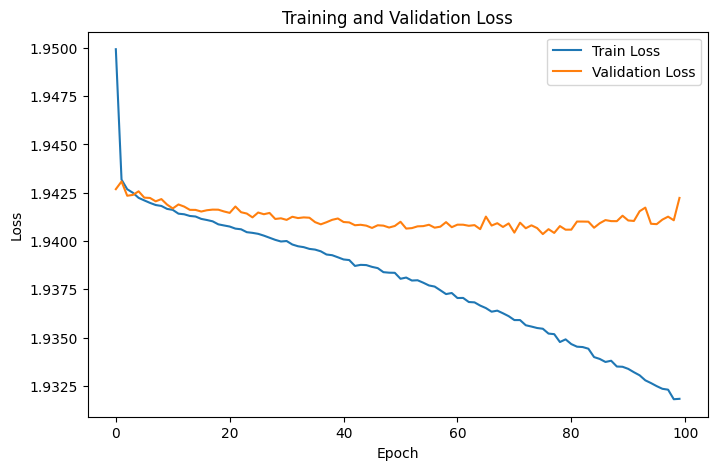

In [10]:
nn_model.train(plot=True)

In [11]:
nn_model.calculate_metrics()

| Metric    | Value  |
|-----------|--------|
| Accuracy  | 0.1628 |
| Precision | 0.1587 |
| Recall    | 0.1628 |
| F1-score  | 0.1473 |


{'accuracy': 0.1628,
 'precision': 0.15871120910926775,
 'recall': 0.1628,
 'f1': 0.14731772000868612}

In [12]:
predictions = nn_model.predict()

In [13]:
predictions = predictions.replace(index_to_fertilizer)
predictions["Fertilizer Name"] = predictions.astype(str).agg(' '.join, axis=1)
predictions = predictions[["Fertilizer Name"]]

In [14]:
predictions.insert(0, "id", test_data_id.values)

In [15]:
predictions.head()

,id,Fertilizer Name
0,750000,DAP 20-20 28-28
1,750001,17-17-17 14-35-14 28-28
2,750002,20-20 10-26-26 DAP
3,750003,14-35-14 10-26-26 17-17-17
4,750004,20-20 10-26-26 17-17-17


In [16]:
predictions.to_csv('/kaggle/working/res.csv',index=False)